In [1]:
%load_ext autoreload
%autoreload 2
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from src.features.q3_plots import *
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, RocCurveDisplay
import src.features.feature_engineering_2 as feng2
import joblib

In [2]:
import os

# Retrieve the API key from environment variables
api_key = os.environ.get('COMET_API_KEY')

if api_key is not None:
    print("API Key found.")
else:
    print("API Key not found.")

API Key found.


In [5]:
try:
    if not os.path.exists("..\data\models"):
        os.mkdir("..\data\models")
except OSError:
    print("Erreur lors de la création du répertoire")

In [4]:
# Chargemenet du dataset
data = pd.read_csv('../data/datasets/csv_files/2016-2019-v2.csv')
data.columns

Index(['period', 'period_type', 'period_time', 'game_seconds', 'gameID',
       'attacking_team_id', 'attacking_team_name', 'shooter', 'goalie',
       'shot_type', 'x_coordinate', 'y_coordinate', 'strength',
       'last_event_type', 'last_event_x', 'last_event_y',
       'time_since_last_event', 'distance_from_last_event',
       'powerplay_duration', 'home_team_players', 'away_team_players',
       'distance_to_net', 'shot_angle', 'is_goal', 'is_empty_net', 'rebound',
       'angle_change', 'speed'],
      dtype='object')

### Question 1

In [6]:
# Sélection des caractéristiques distance_to_net et shot_angle et des labels is_goal
df1 = data[['distance_to_net', 'shot_angle' , 'is_goal']]
df1.head()

,distance_to_net,shot_angle,is_goal
0,13.0,23.0,0
1,13.0,77.0,0
2,76.0,-30.0,0
3,58.0,-15.0,0
4,62.0,27.0,0


In [7]:
X1, y1 = df1[['distance_to_net', 'shot_angle']].values , df1['is_goal'].values
# Séparation des données en ensembles d'entraînement et de test
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [8]:
# Instanciation du classificateur XGBoost
xgb_classifier1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Entraînement du modèle
xgb_classifier1.fit(X_train1, y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [9]:
# Prédictions sur l'ensemble de validation
y_pred1 = xgb_classifier1.predict(X_val1)
y_pred_proba1 = xgb_classifier1.predict_proba(X_val1)[:, 1]

In [17]:
# Accuracy
accuracy1 = accuracy_score(y_val1, y_pred1)

# Recall
recall1 = recall_score(y_val1, y_pred1)

# F1 Score
f1_score1 = f1_score(y_val1, y_pred1)

# AUC Score
auc1 = roc_auc_score(y_val1, y_pred_proba1)

print("Accuracy:", accuracy1)
print("Recall:", recall1)
print("F1 Score:", f1_score1)
print("AUC Score:", auc1)

Accuracy: 0.9042926145216579
Recall: 0.0018988200189882002
F1 Score: 0.003784295175023652
AUC Score: 0.7171453459747072


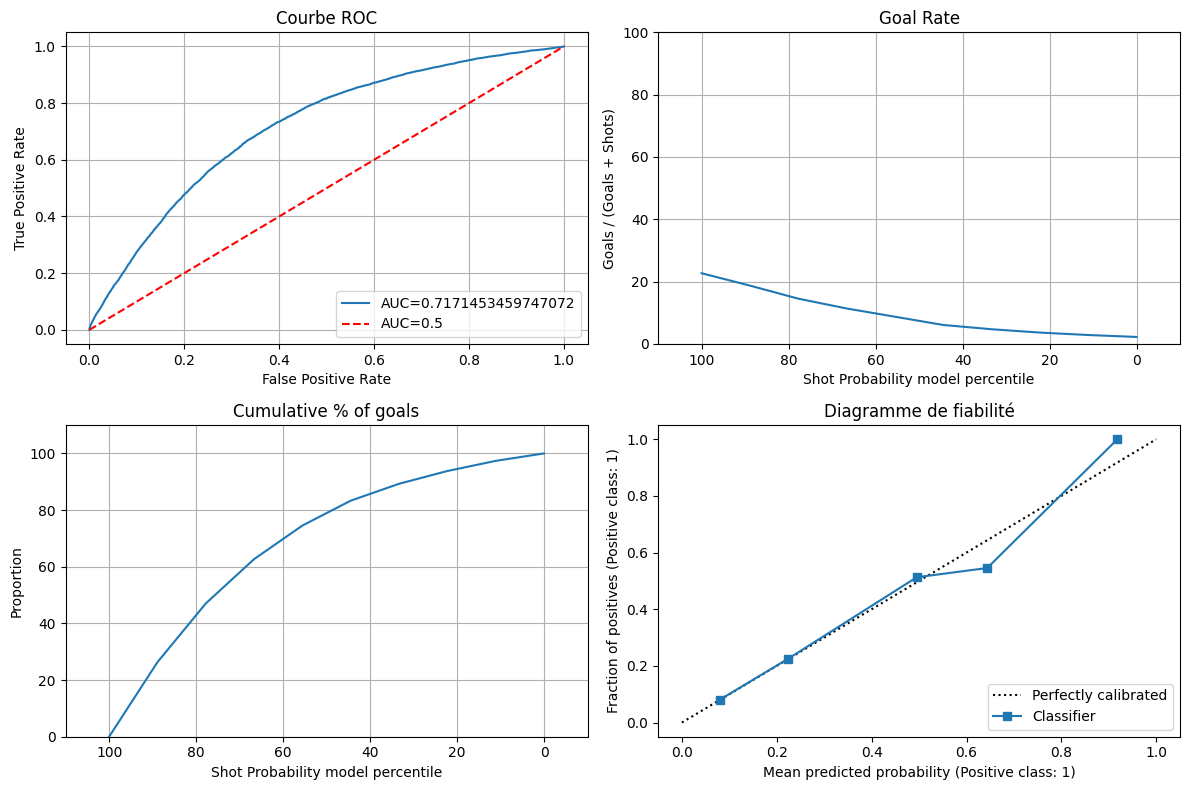

In [23]:
plot_metrics(y_val1, y_pred_proba1)

In [13]:
joblib.dump(xgb_classifier1, r'..\data\models\xgb_model_base.joblib')

['..\\data\\models\\xgb_model_base.joblib']

In [10]:
from comet_ml import Experiment

experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: xgboost, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tedoul/ift6758-project/aefdcd6ea20647dd8abeb977f2c0ac1c



In [14]:
#nommer l'expérience
experiment.set_name("xgb_model_base")

In [19]:
experiment.log_metrics({"accuracy": accuracy1, "recall": recall1, "f1-score": f1_score1, "auc": auc1})
experiment.log_confusion_matrix(y_val1, y_pred1)

{'web': 'https://www.comet.com/api/asset/download?assetId=b2451a1d9b804b039fa8bc0ef4354db0&experimentKey=aefdcd6ea20647dd8abeb977f2c0ac1c',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=b2451a1d9b804b039fa8bc0ef4354db0&experimentKey=aefdcd6ea20647dd8abeb977f2c0ac1c',
 'assetId': 'b2451a1d9b804b039fa8bc0ef4354db0'}

In [21]:
experiment.log_figure(figure=plot_fiability_diagram(y_val1, y_pred_proba1), figure_name="Diagrame de fiabilité")
plt.close()

In [23]:
#enregistrer le modele dans comet 
#ajouter des tags informatifs

experiment.log_model(name="xgb_model_base", file_or_folder=r"..\data\models\xgb_model_base.joblib")
experiment.add_tags(["XGBoost", "Model basique, sans hypertuning", "Features: Shot distance, shot angle"])

In [25]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/aefdcd6ea20647dd8abeb977f2c0ac1c
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.9042926145216579
COMET INFO:     auc      : 0.7171453459747072
COMET INFO:     f1-score : 0.003784295175023652
COMET INFO:     recall   : 0.0018988200189882002
COMET INFO:   Others:
COMET INFO:     Name : xgb_model_base
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (306.01 KB)
COM

### Question 2

In [26]:
data.columns

Index(['period', 'period_type', 'period_time', 'game_seconds', 'gameID',
       'attacking_team_id', 'attacking_team_name', 'shooter', 'goalie',
       'shot_type', 'x_coordinate', 'y_coordinate', 'strength',
       'last_event_type', 'last_event_x', 'last_event_y',
       'time_since_last_event', 'distance_from_last_event',
       'powerplay_duration', 'home_team_players', 'away_team_players',
       'distance_to_net', 'shot_angle', 'is_goal', 'is_empty_net', 'rebound',
       'angle_change', 'speed'],
      dtype='object')

In [5]:
X2, y2 = feng2.select_features(data)

c:\users\mk_ya\desktop\ift6758-projet\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [36]:
# Séparation des données en ensembles d'entraînement et de test
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [37]:
X_train2.dtypes

period                                  int64
game_seconds                            int64
x_coordinate                          float64
y_coordinate                          float64
distance_to_net                       float64
shot_angle                            float64
shot_type                               int64
last_event_x                          float64
last_event_y                          float64
time_since_last_event                   int64
distance_from_last_event              float64
rebound                                 int32
angle_change                          float64
speed                                 float64
powerplay_duration                      int64
home_team_players                       int64
away_team_players                       int64
last_event_type_Blocked Shot          float64
last_event_type_Faceoff               float64
last_event_type_Game End              float64
last_event_type_Game Official         float64
last_event_type_Giveaway          

In [40]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb


param_grid = {
    'max_depth': [3, 6, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'min_child_weight': [1, 2, 5, 10],
    'subsample': [0.6, 0.8, 1]
}

# Initialize the XGBoost classifier
xgb_classifier2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=xgb_classifier2, param_distributions=param_grid, 
                                   n_iter=50, cv=5, n_jobs=-1, scoring='accuracy', verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train2, y_train2)

# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy found: ", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1}
Best accuracy found:  0.906122183990132


In [ ]:
xgb_classifier2 = grid_search.best_estimator_
# Prédictions sur l'ensemble de validation
y_pred2 = xgb_classifier2.predict(X_val2.values)
y_pred_proba2 = xgb_classifier2.predict_proba(X_val2.values)[:, 1]

In [ ]:
plot_metrics(y_val2.values, y_pred_proba2)

### Question 3

In [59]:
feature_importances = xgb_classifier2.feature_importances_

feature_names = X_train2.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

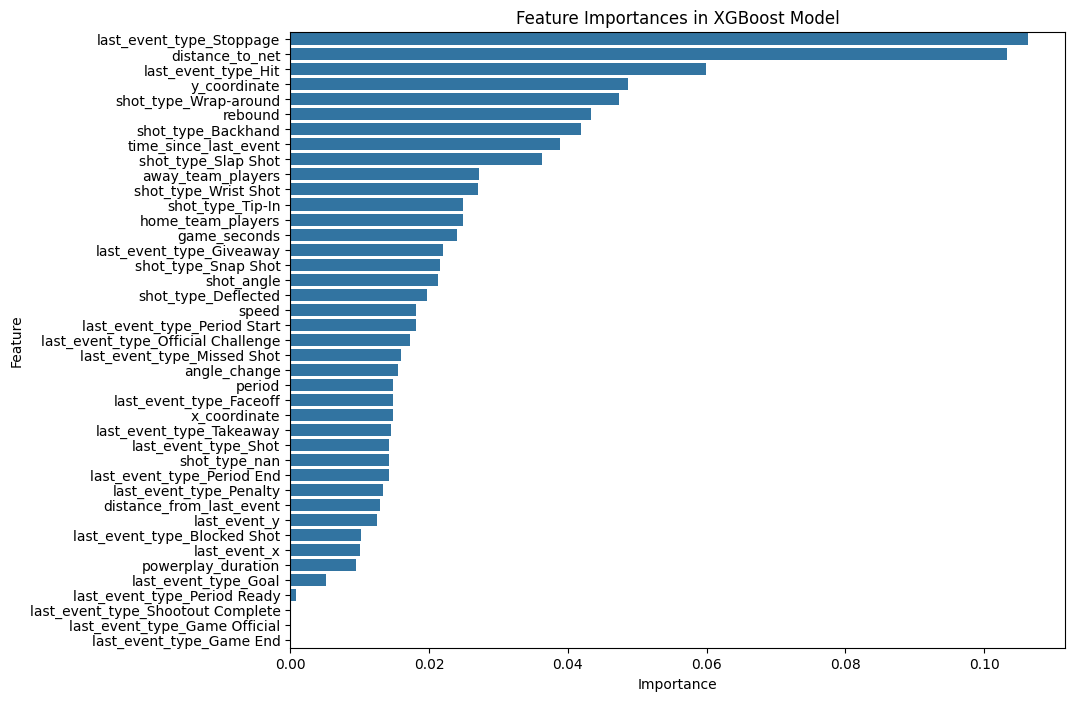

In [60]:
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importances in XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [41]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

best_params = random_search.best_params_

xgb_model3 = xgb.XGBClassifier(**best_params)
rfecv = RFECV(estimator=xgb_model3, step=1, cv=StratifiedKFold(5), scoring='accuracy', verbose=2)
rfecv.fit(X_train2, y_train2)

Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 featu

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=2,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=500,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...),
      scoring='accuracy', verbose=2)

Optimal number of features: 28
Best features: Index(['period', 'game_seconds', 'x_coordinate', 'y_coordinate',
       'distance_to_net', 'shot_angle', 'shot_type', 'last_event_x',
       'last_event_y', 'time_since_last_event', 'distance_from_last_event',
       'rebound', 'angle_change', 'speed', 'powerplay_duration',
       'home_team_players', 'away_team_players',
       'last_event_type_Blocked Shot', 'last_event_type_Faceoff',
       'last_event_type_Giveaway', 'last_event_type_Hit',
       'last_event_type_Missed Shot', 'last_event_type_Official Challenge',
       'last_event_type_Penalty', 'last_event_type_Period End',
       'last_event_type_Period Start', 'last_event_type_Stoppage',
       'last_event_type_Takeaway'],
      dtype='object')


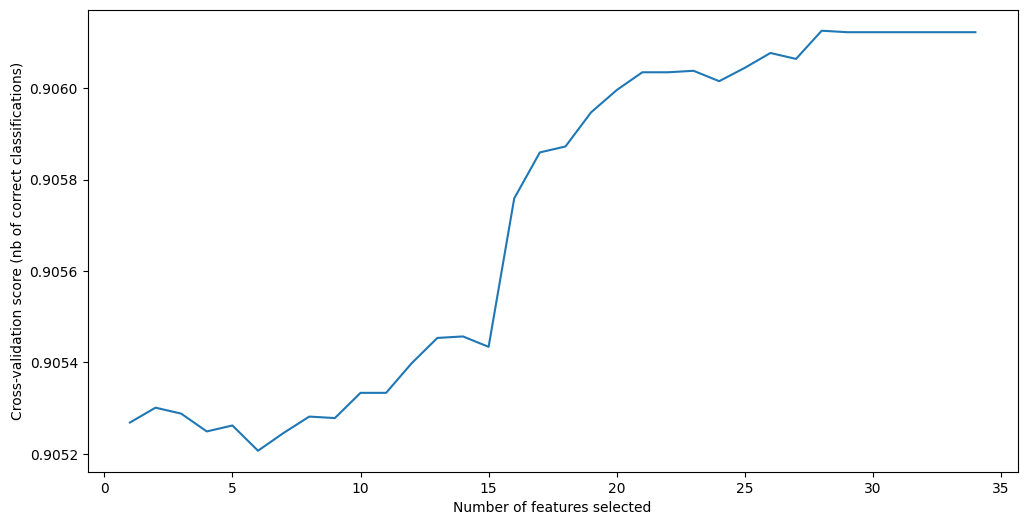

In [44]:
print("Optimal number of features:", rfecv.n_features_)
print("Best features:", X_train2.columns[rfecv.support_])

# Plotting the number of features against cross-validation scores
import matplotlib.pyplot as plt

cross_val_scores = rfecv.cv_results_['mean_test_score']

plt.figure(figsize=(12, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(cross_val_scores) + 1), cross_val_scores)
plt.show()
